# Study of whiten by gwpy

Let's first get some data from gwosc

In [1]:
import sys

sys.path.insert(0, "../src/")

import timeserie

event = timeserie.fetch_by_name("GW150914-v3", "H1")

/home/riccardo/timeseries/jupyter/../src/timeserie/download.py:118: UserWarning: Duration of downloaded data set to: 99.99951171875
  warnings.warn(f"Duration of downloaded data set to: {new_duration}")
/home/riccardo/timeseries/jupyter/../src/timeserie/convert.py:151: UserWarning: dt inserted (1126259462.4) will be ignored
  warnings.warn(f"dt inserted ({dt}) will be ignored")
/home/riccardo/timeseries/jupyter/../src/timeserie/convert.py:155: UserWarning: duration inserted (99.99951171875) will be ignored
  warnings.warn(f"duration inserted ({duration}) will be ignored")


In [2]:
# Build a timeserie from gwpy
from gwpy.timeseries import TimeSeries

ts = TimeSeries(event.strain)

Let's visualize the data

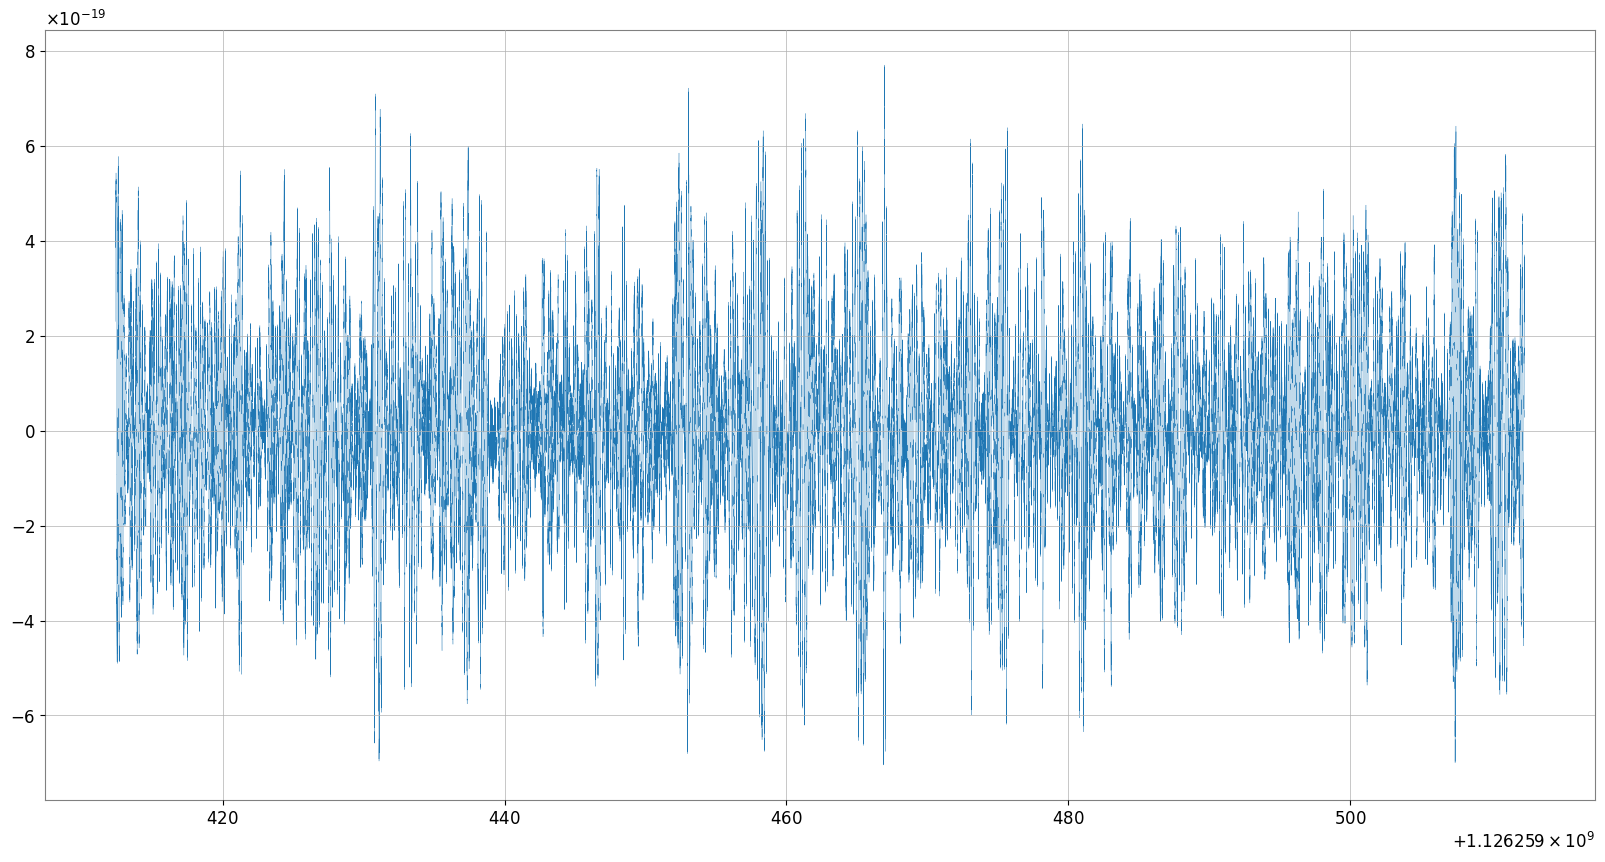

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(event.gps_times, event.strain, lw="0.2")
plt.show()

In `gwpy` the method `whiten()` can be called from the object itself:

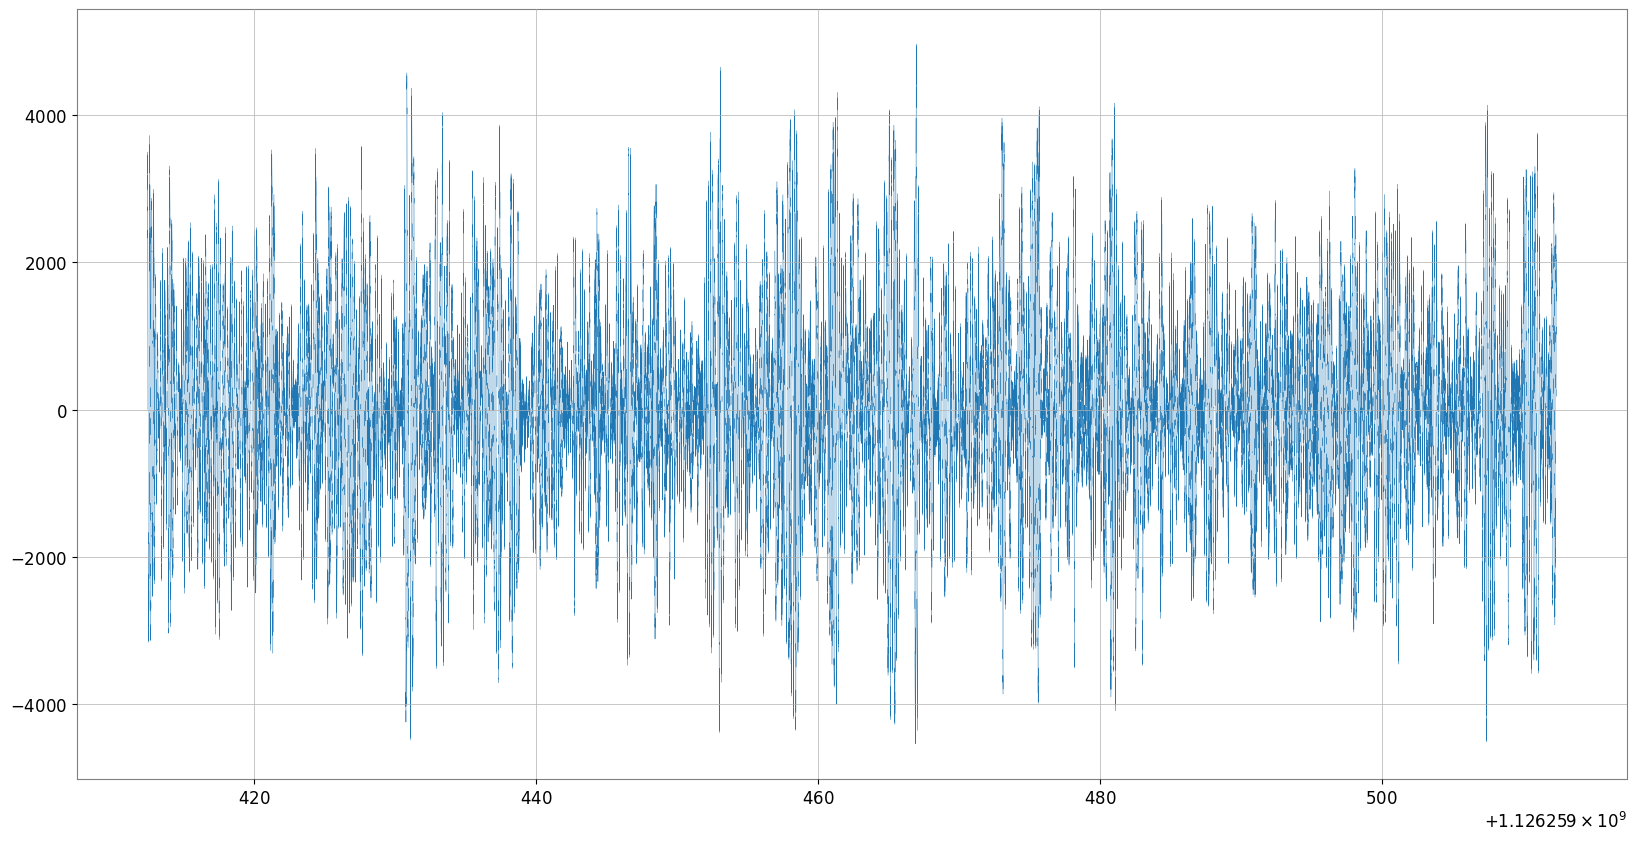

In [4]:
whitened_data = ts.whiten()

plt.figure(figsize=(20, 10))
plt.plot(event.gps_times, whitened_data.value, lw=0.2)
plt.show()

So the first effect observed is that the scale has changed. Let's compare normalized data

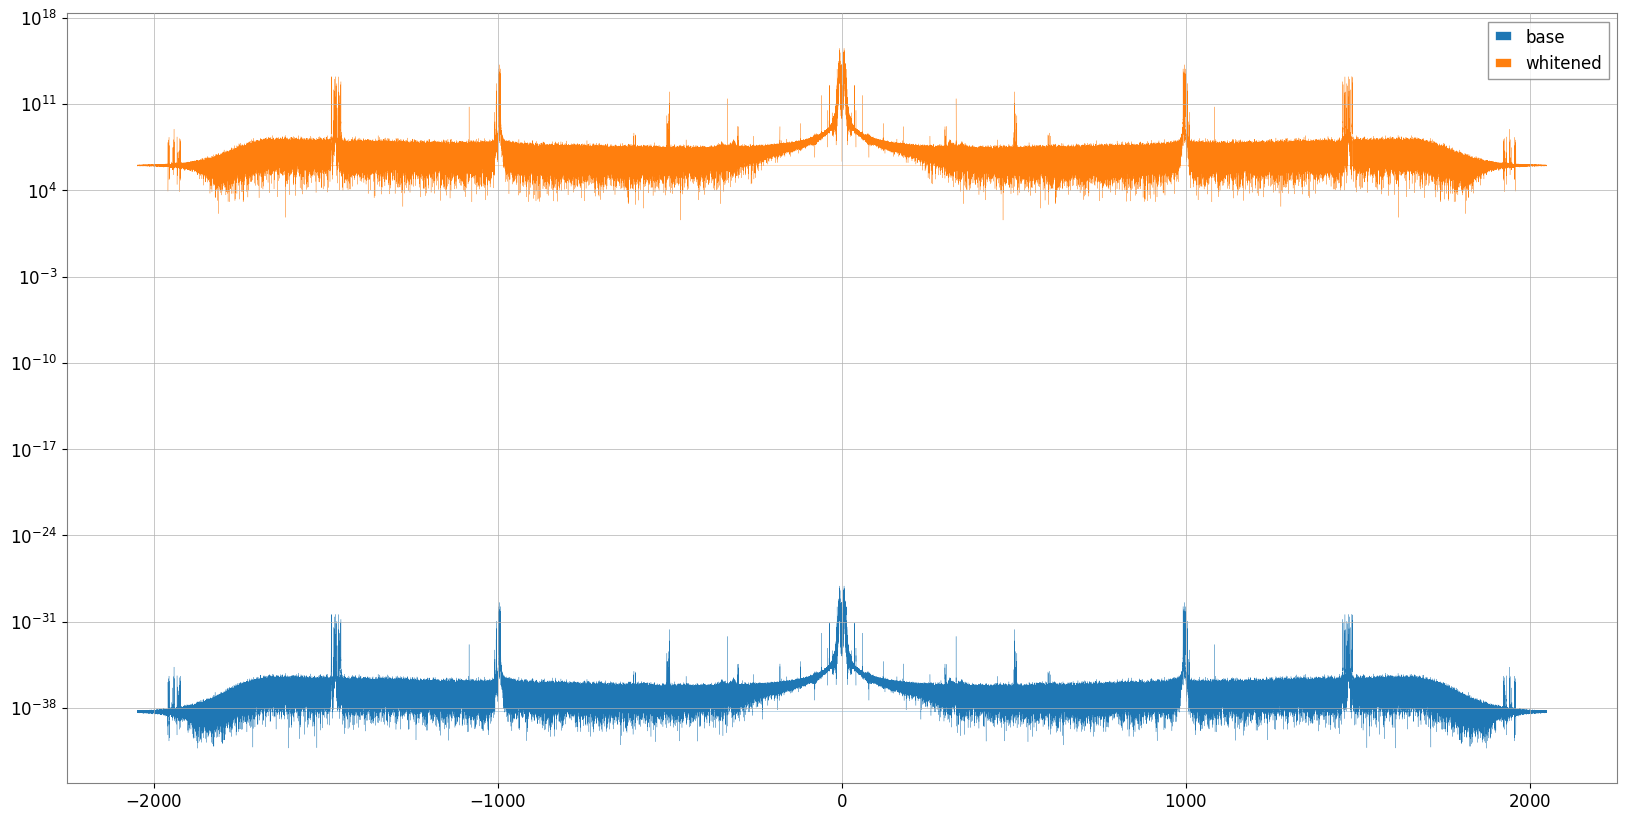

In [13]:
from sklearn import preprocessing
import numpy

fft = numpy.fft.fft(event.strain)
white_fft = numpy.fft.fft(whitened_data.value)

freqs = numpy.fft.fftfreq(event.strain.shape[0], event.attrs.dt)

plt.figure(figsize=(20, 10))
plt.semilogy(freqs, numpy.abs(fft) ** 2, lw=0.2, label="base")
plt.semilogy(freqs, numpy.abs(white_fft) ** 2, lw=0.2, label="whitened")
plt.legend()
plt.show()

Let's explore the whiten function

```python
def whiten(self, fftlength=None, overlap=0, method=DEFAULT_FFT_METHOD,
            window='hann', detrend='constant', asd=None,
            fduration=2, highpass=None, **kwargs):
    # compute the ASD
    fftlength = fftlength if fftlength else _fft_length_default(self.dt)
    if asd is None:
        asd = self.asd(fftlength, overlap=overlap,
                        method=method, window=window, **kwargs)
    asd = asd.interpolate(1./self.duration.decompose().value)
    # design whitening filter, with highpass if requested
    ncorner = int(highpass / asd.df.decompose().value) if highpass else 0
    if isinstance(window, (str, tuple)):
        ntaps = int((fduration * self.sample_rate).decompose().value)
    else:
        window = numpy.asarray(window)
        ntaps = len(window)
    tdw = filter_design.fir_from_transfer(1/asd.value, ntaps=ntaps,
                                            window=window, ncorner=ncorner)
    # condition the input data and apply the whitening filter
    in_ = self.copy().detrend(detrend)
    out = in_.convolve(tdw, window=window)
    return out * numpy.sqrt(2 * in_.dt.decompose().value)
```

So the steps are the following:

- Compute the Amplitude Spectral Density (ASD) and interpolate:
    ```python
        self.asd(fftlength, overlap=overlap,
                            method=method, window=window, **kwargs)
        asd = asd.interpolate(1./self.duration.decompose().value)
    ```
- Eventually apply highpass filter:
    ```python
        ncorner = int(highpass / asd.df.decompose().value) if highpass else 0
    ```
- Design Finite Impulse Response (FIR) filter:
    ```python
        tdw = filter_design.fir_from_transfer(1/asd.value, ntaps=ntaps,
                                                window=window, ncorner=ncorner)
    ```
- Apply whitening filter:
    ```python
        in_ = self.copy().detrend(detrend)
        out = in_.convolve(tdw, window=window)
        return out * numpy.sqrt(2 * in_.dt.decompose().value)
    ```


I will go through every step analyzing how `gwpy` handles them.